# Long-lenght legal documents classification for spanish corpora

In this notebook we'll classify long length legal documents: *court ruling*. The corpus was generated by a sample of Supreme Court of Buenos Aires (Argentina) on line data base. The goal of the task is to predict the judicial branch -a categorical variable in our dataset- through training a supervised statistical model. So, we'll first clean de data withe same NLP technics, then we'll vectorize the document with *doc2vec* and finally classify them. In order to judge the performance of the model we'll evaluate the results.

Referencias consultadas

Github notebooks: [1](https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb), [2](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb), [3](https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb), [4](https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb), [5](https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d)


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
f = open('data/corpus_textosfallos.json', encoding="utf8")
d = open('data/corpus_fallosmetdat.json', encoding="utf8")
fallos = json.load(f)
fdatos = json.load(d)

/home/sebacastillo/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


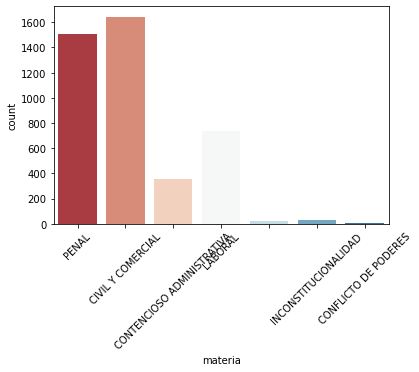

In [8]:
df = pd.DataFrame(fdatos)
chart = sns.countplot(df['materia'], palette='RdBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);


Filtrando bd para trabajar con categorías con observaciones

In [ ]:
df['materia'].value_counts()
df['tipo_fallo'].value_counts()
materias_elegidas = ['CIVIL Y COMERCIAL','PENAL','LABORAL']
tipo_felegidos = ["Sentencia Interlocutoria", 'Sentencia Definitiva']
dfxmat = df[df['materia'].notna()]
dfxmat = df[df['materia'].isin(materias_elegidas)]
dfxmat['materia'].value_counts()

In [ ]:
dfxtf = df[df['tipo_fallo'].isin(tipo_felegidos)]